In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import missingno as msno
import seaborn as sns
import os

In [2]:
path = 'E:\\Data_Science\\OpenClassRoom\\Projet 5\\archive\\'
cust_df=pd.read_csv(path + 'olist_customers_dataset.csv')
geo_df=pd.read_csv(path +'olist_geolocation_dataset.csv')
ord_it_df=pd.read_csv(path + 'olist_order_items_dataset.csv')
ord_pay_df=pd.read_csv(path + 'olist_order_payments_dataset.csv')
ord_rev_df=pd.read_csv(path + 'olist_order_reviews_dataset.csv')
ord_df=pd.read_csv(path + 'olist_orders_dataset.csv')
prod_df=pd.read_csv(path + 'olist_products_dataset.csv')
sell_df=pd.read_csv(path + 'olist_sellers_dataset.csv')

In [3]:
dfs = {0:cust_df,1:geo_df,2:ord_it_df,3:ord_pay_df,4:ord_rev_df,5:ord_df,6:prod_df,7:sell_df}

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 5 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   customer_id               99441 non-null  object
 1   customer_unique_id        99441 non-null  object
 2   customer_zip_code_prefix  99441 non-null  int64 
 3   customer_city             99441 non-null  object
 4   customer_state            99441 non-null  object
dtypes: int64(1), object(4)
memory usage: 3.8+ MB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000163 entries, 0 to 1000162
Data columns (total 5 columns):
 #   Column                       Non-Null Count    Dtype  
---  ------                       --------------    -----  
 0   geolocation_zip_code_prefix  1000163 non-null  int64  
 1   geolocation_lat              1000163 non-null  float64
 2   geolocation_lng              1000163 non-null  float64
 3   geolocation_city             1000163 non-n

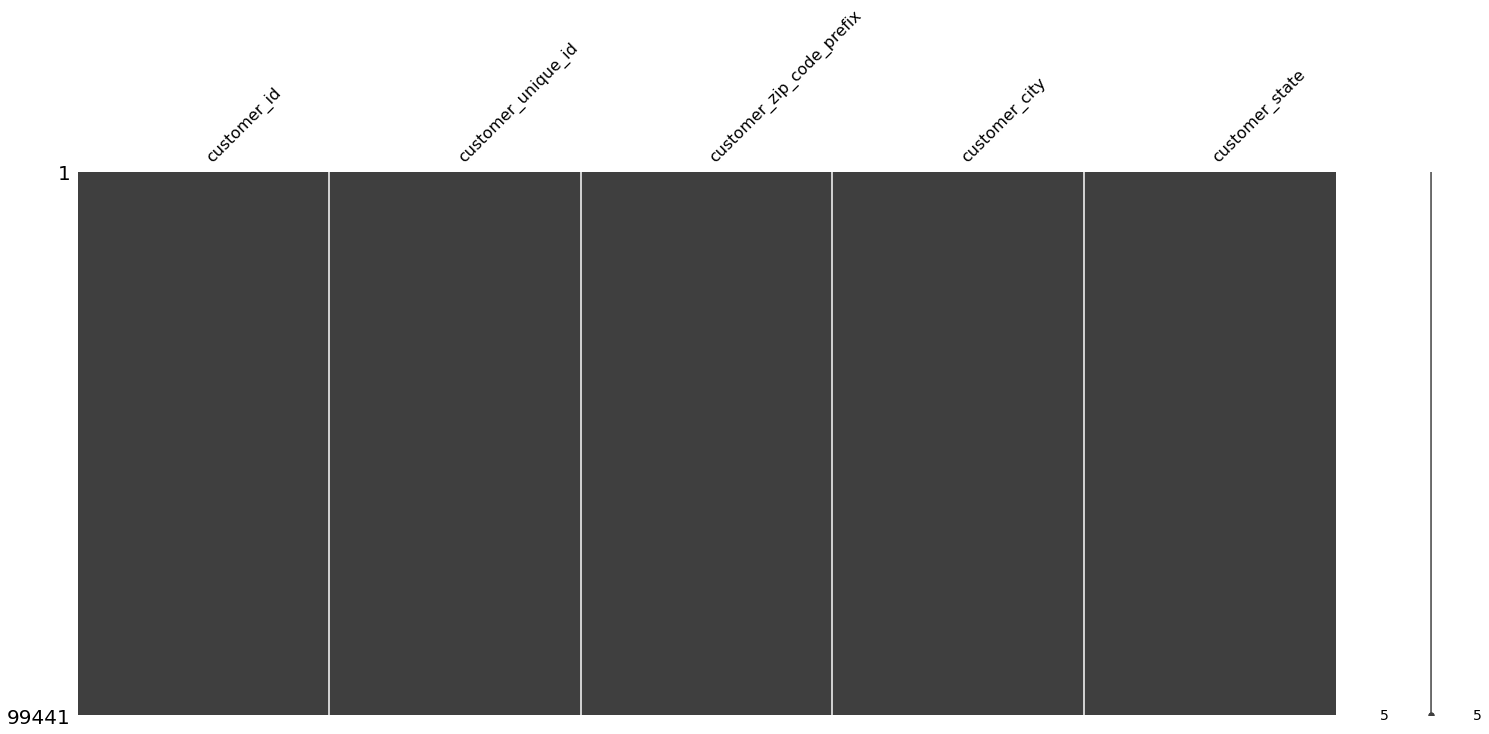

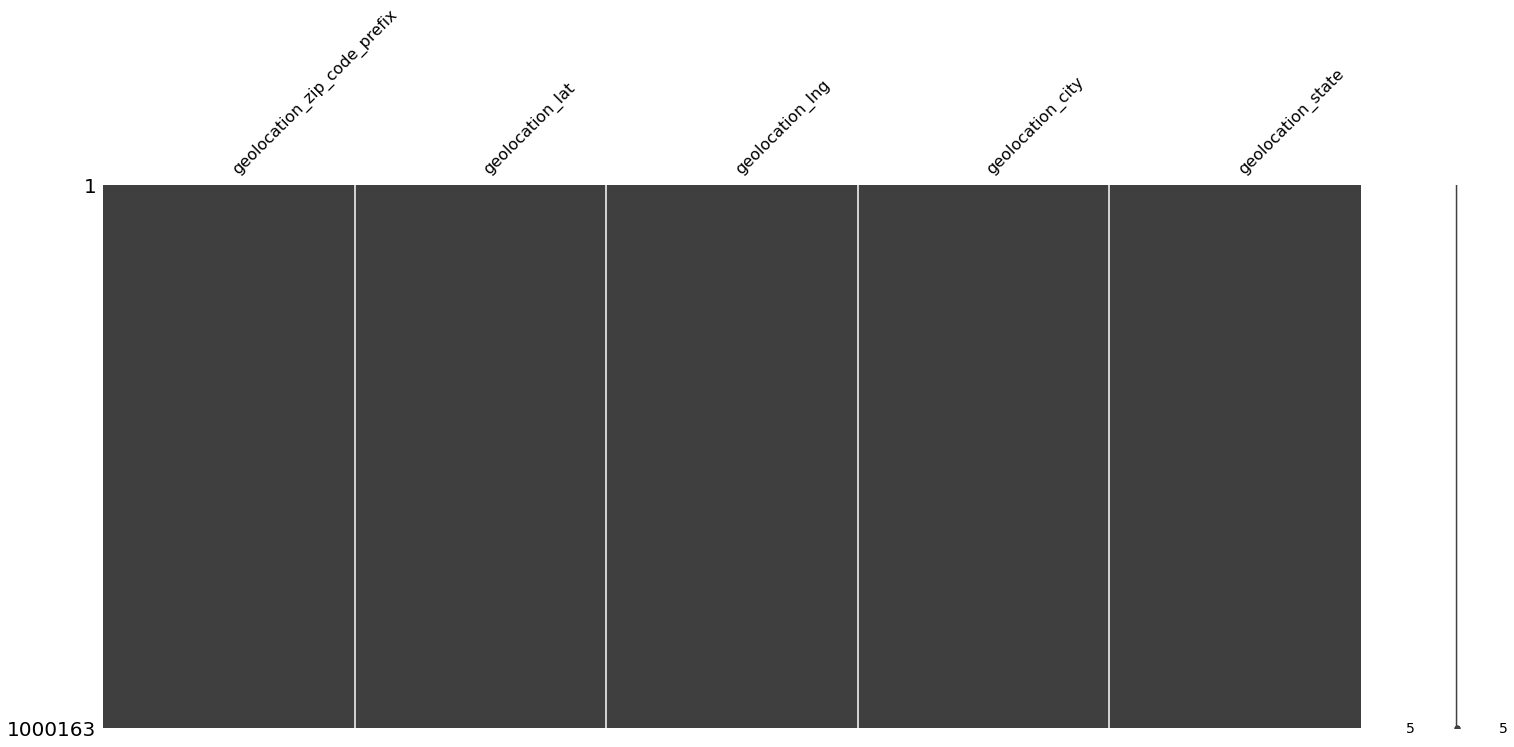

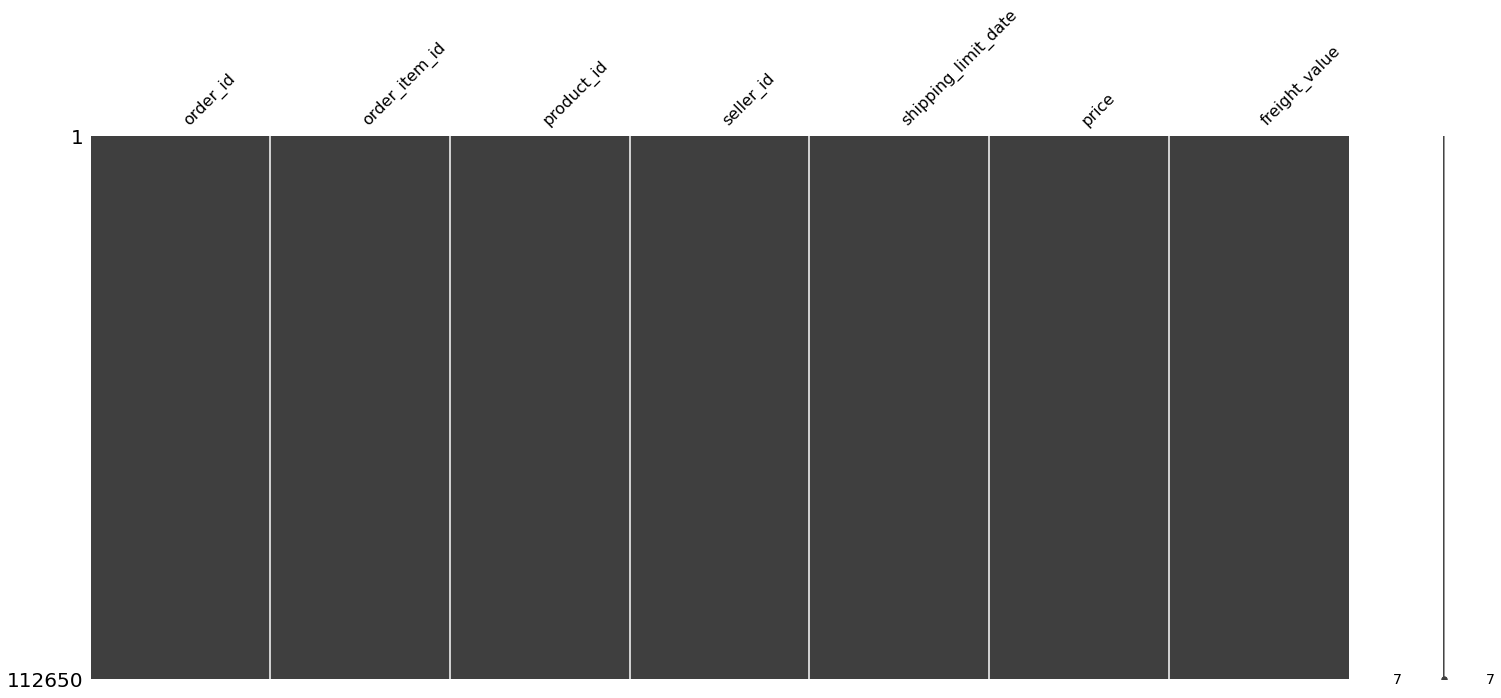

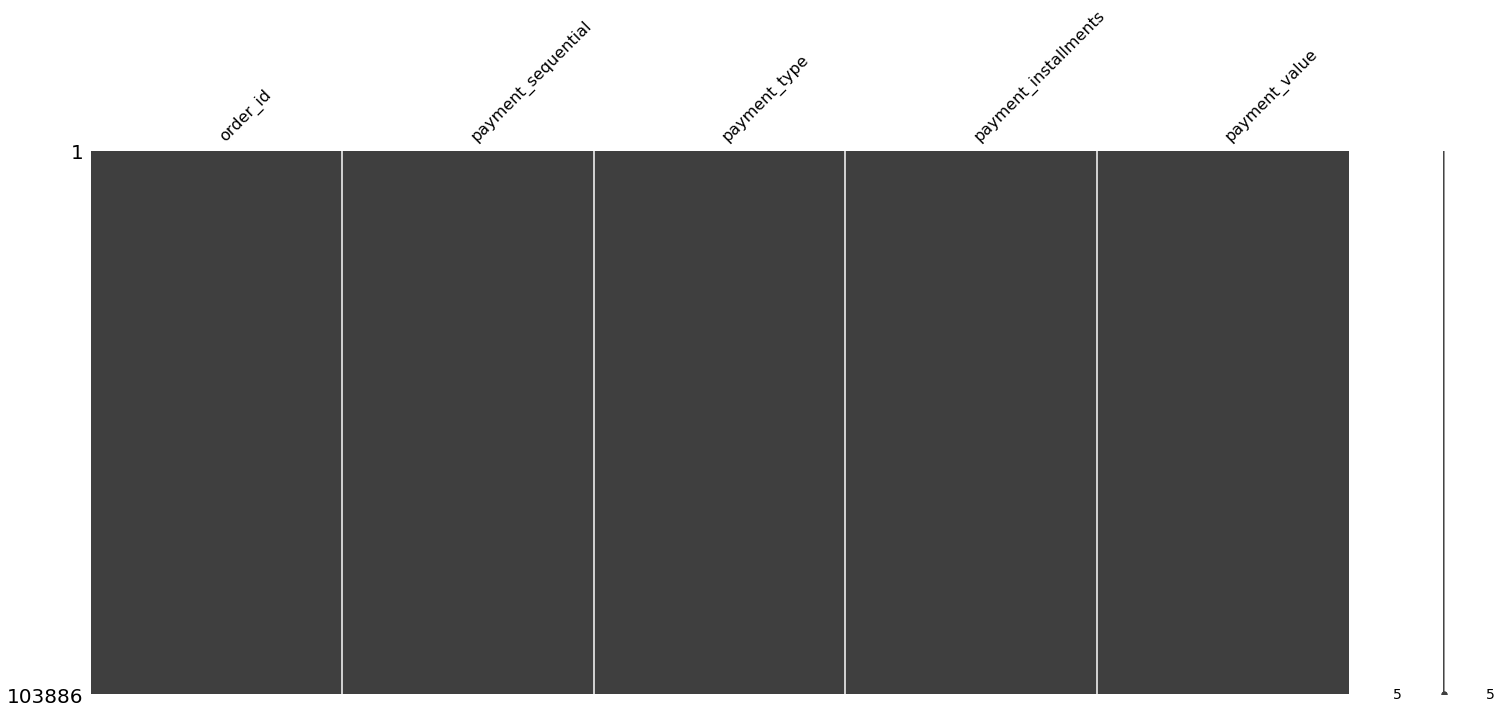

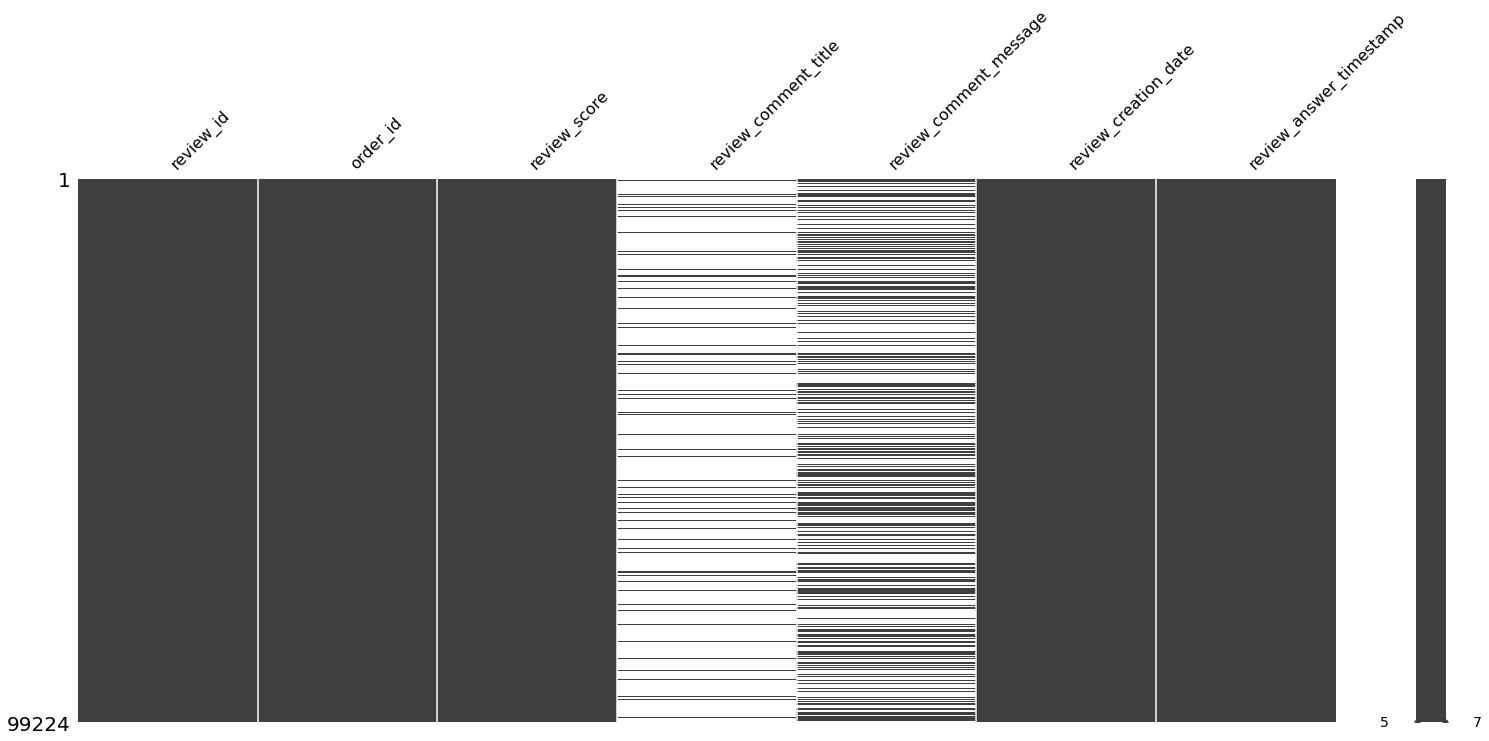

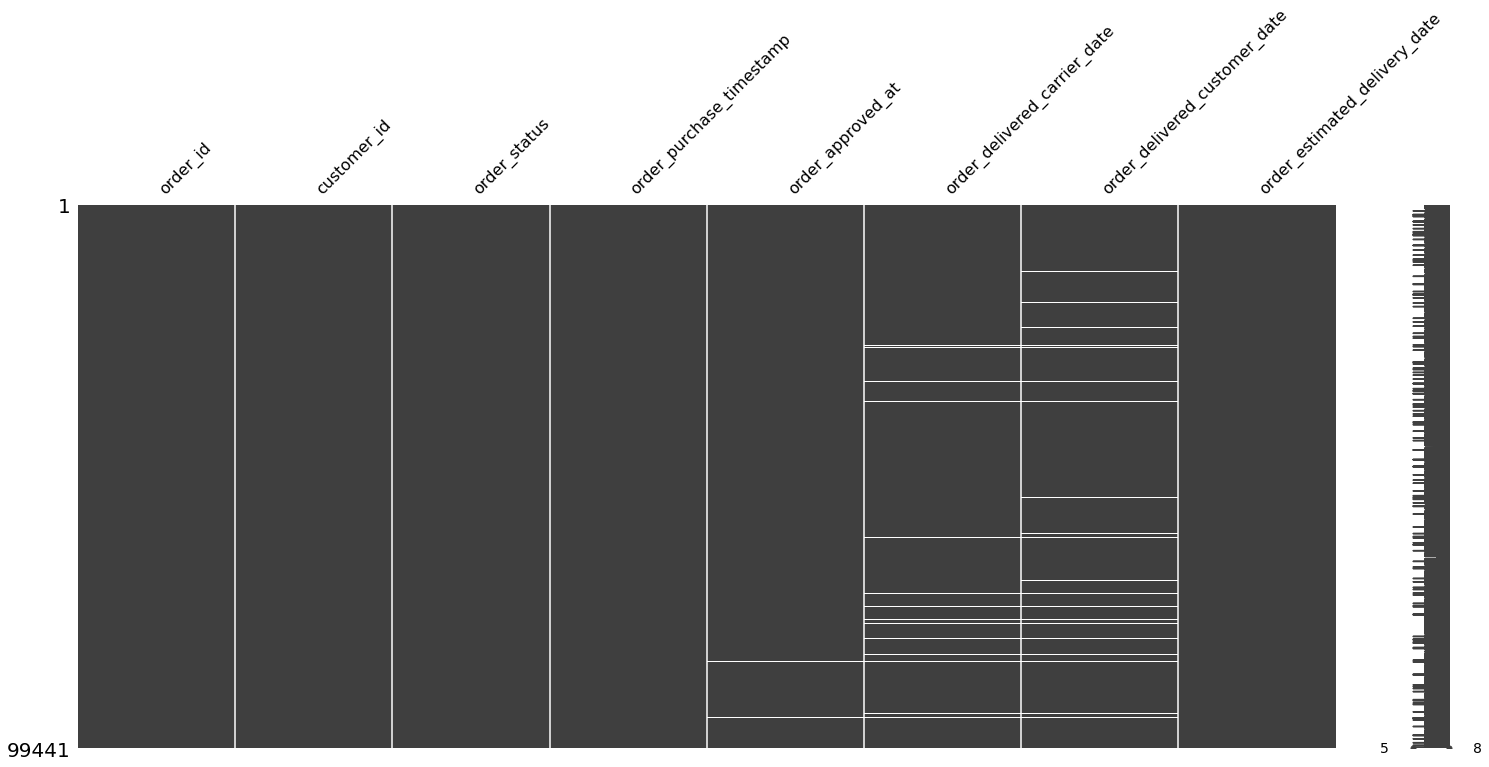

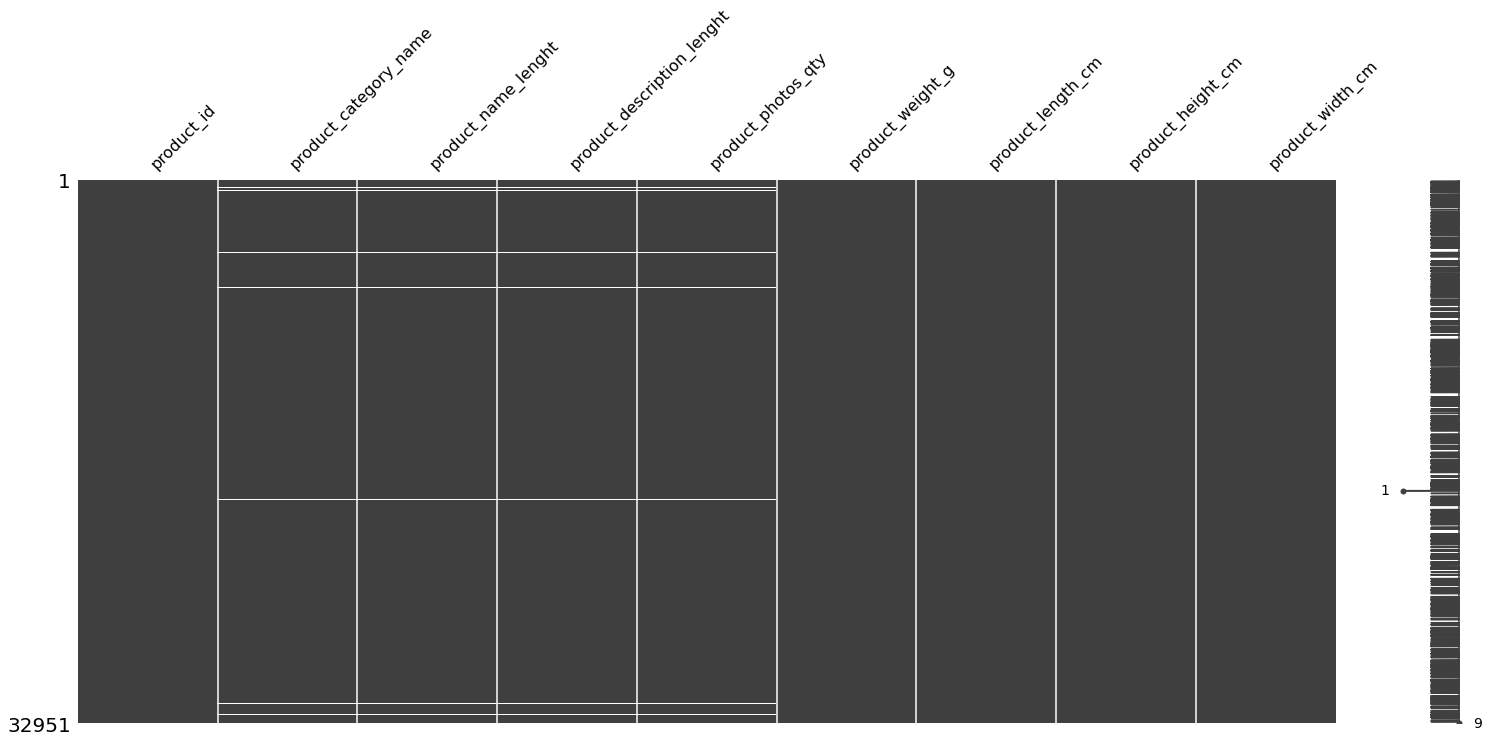

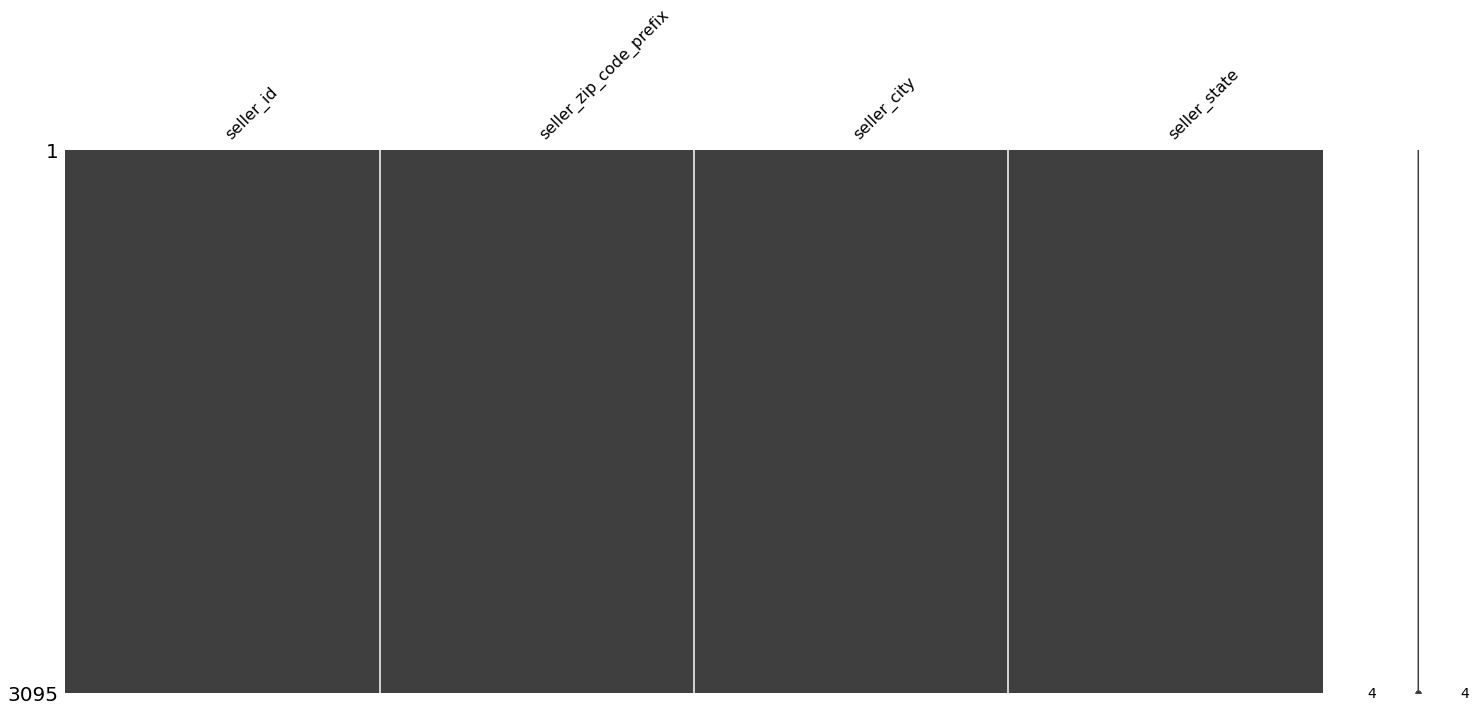

In [4]:
for i in dfs:
    print(dfs[i].info())
    msno.matrix(dfs[i])

In [5]:
#get the customers that ordered more than once
multi_cust_df = dfs[0][dfs[0].groupby('customer_unique_id').customer_unique_id.transform('count') > 1]

#get their customer_id
multi_custom = multi_cust_df[['customer_id','customer_unique_id']]
multi_id = multi_custom['customer_id']
multi_uni_id = multi_custom['customer_unique_id']
#get their order_id
multi_order_df = dfs[5][dfs[5]['customer_id'].isin(multi_id)]
multi_order_id = multi_order_df['order_id']

multi_pay_df = dfs[3][dfs[3]['order_id'].isin(multi_order_id)]



In [6]:
print(dfs[0]['customer_id'].unique().shape[0])
print(dfs[0]['customer_unique_id'].unique().shape[0])

99441
96096


In [7]:
import time
import datetime

def days(x):
    td = time.time()
    t = time.mktime(datetime.datetime.strptime(str(x),"%Y-%m-%d %H:%M:%S").timetuple())
    d = int((td - t)/86400)
    return d

In [8]:
#build the working df
df = pd.DataFrame(multi_custom)
df = df.set_index('customer_id')
df = df.join(multi_order_df[['customer_id','order_id', 'order_purchase_timestamp']].set_index('customer_id'))
temp = pd.DataFrame()
temp['order_total'] = multi_pay_df.groupby('order_id').payment_value.sum()
df = df.join(temp, on = 'order_id')
df['days_since_order'] = df['order_purchase_timestamp'].apply(days)
print(df.info())

<class 'pandas.core.frame.DataFrame'>
Index: 6342 entries, 879864dab9bc3047522c92c82e1212b8 to d9110683c7a282144e9fc97660026a28
Data columns (total 5 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   customer_unique_id        6342 non-null   object 
 1   order_id                  6342 non-null   object 
 2   order_purchase_timestamp  6342 non-null   object 
 3   order_total               6342 non-null   float64
 4   days_since_order          6342 non-null   int64  
dtypes: float64(1), int64(1), object(3)
memory usage: 555.3+ KB
None


In [39]:
#build the model df
md_df = pd.DataFrame(index = df['customer_unique_id'].unique())
#feature  = number of order
md_df['n_order'] = df.groupby('customer_unique_id').order_id.count()
#feature  = total value of orders
md_df['payment_total'] = df.groupby('customer_unique_id').order_total.agg('sum')
#feature  = mean and std of orders
md_df['payment_mean'] = df.groupby('customer_unique_id').order_total.agg('mean')
md_df['payment_std'] = df.groupby('customer_unique_id').order_total.agg('std')
#feature  = days since last order
md_df['days_since_last_order'] = df.groupby('customer_unique_id').days_since_order.agg('min')

print(md_df.info(),md_df.head())

<class 'pandas.core.frame.DataFrame'>
Index: 2997 entries, 4c93744516667ad3b8f1fb645a3116a4 to da29b8a3970adddb9ed2dc8a492065af
Data columns (total 5 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   n_order                2997 non-null   int64  
 1   payment_total          2997 non-null   float64
 2   payment_mean           2997 non-null   float64
 3   payment_std            2997 non-null   float64
 4   days_since_last_order  2997 non-null   int64  
dtypes: float64(3), int64(2)
memory usage: 140.5+ KB
None                                   n_order  payment_total  payment_mean  \
4c93744516667ad3b8f1fb645a3116a4        2         565.88       282.940   
1175e95fb47ddff9de6b2b06188f7e0d        2          83.19        41.595   
295c05e81917928d76245e842748184d        2         281.50       140.750   
e9dd12dca17352644a959d9dea133935        2         113.83        56.915   
e079b18794454de9d2be5c12b4392294        2       

<AxesSubplot:>

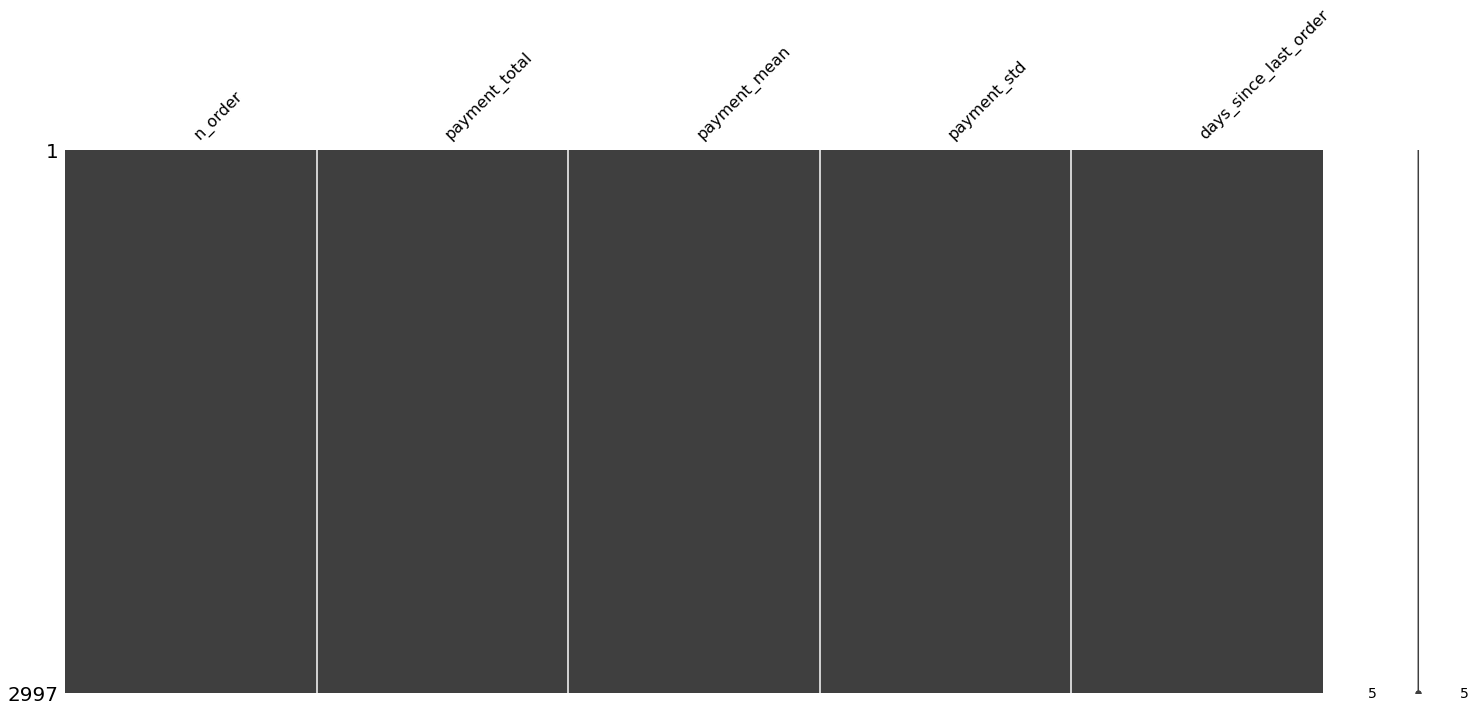

In [40]:
msno.matrix(md_df)

In [ ]:
fig = plt.figure(figsize=(20, 25))
for i in range(n_classes):
    ax = fig.add_subplot(5,3, i+1)
    ax.plot(pre[i], rec[i],label='PR curve')
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('Recall')
    ax.set_ylabel('Precision')
    ax.legend(loc="lower right")
plt.savefig('pr_curve.png', bbox_inches = 'tight')
plt.show()

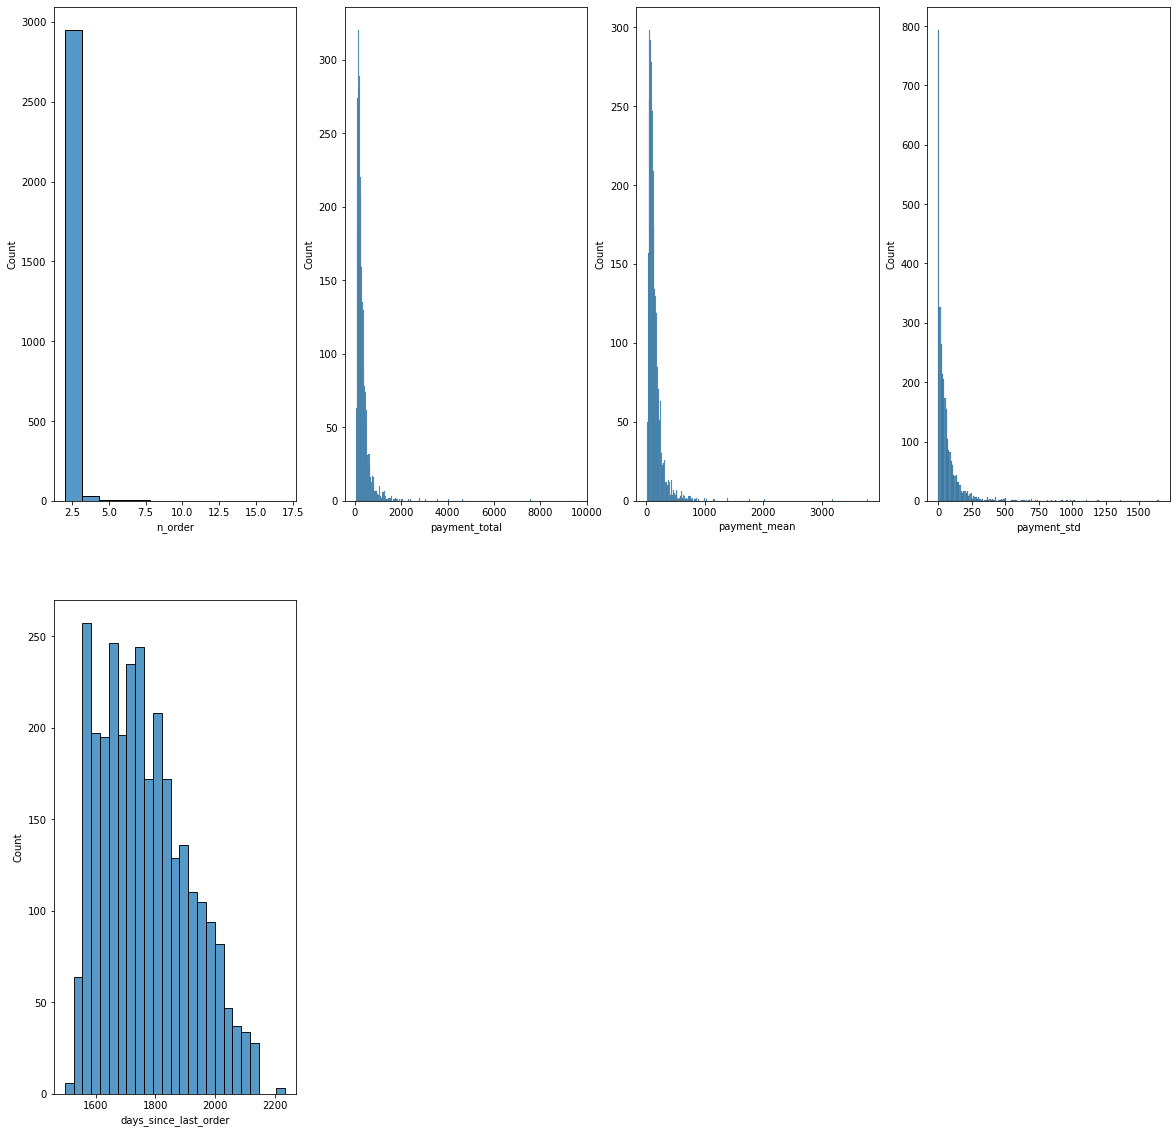

In [46]:

fig = plt.figure(figsize=(20,20))
for i in range(md_df.shape[1]):
    ax = fig.add_subplot(int((md_df.shape[1]/4)+1), 4, i+1)
    sns.histplot(md_df.iloc[:,i], ax = ax)

plt.show()

In [47]:
md_df.to_csv('md_df.csv', index = False)

## Dimention reduction

In [48]:
dim_df = pd.read_csv('md_df.csv')
x = dim_df.values
features = dim_df.columns

In [49]:
dim_df.isna().sum()

n_order                  0
payment_total            0
payment_mean             0
payment_std              0
days_since_last_order    0
dtype: int64

In [50]:
from sklearn import decomposition
from sklearn import preprocessing

pca = decomposition.PCA(n_components = 2)
scaler = preprocessing.StandardScaler()
x_scale = preprocessing.scale(x)

pca.fit(x_scale)

PCA(n_components=2)

In [52]:
scree = (pca.explained_variance_ratio_*100).round(2).cumsum()
print(scree)

[49.36 70.55]


In [53]:
pd.DataFrame(pca.components_, columns = features, index = ['F1', 'F2'])



n_order  payment_total  payment_mean  payment_std  days_since_last_order
F1  0.090216       0.607111      0.611483     0.498090              -0.035676
F2  0.724251       0.040462     -0.100229    -0.105638              -0.672769

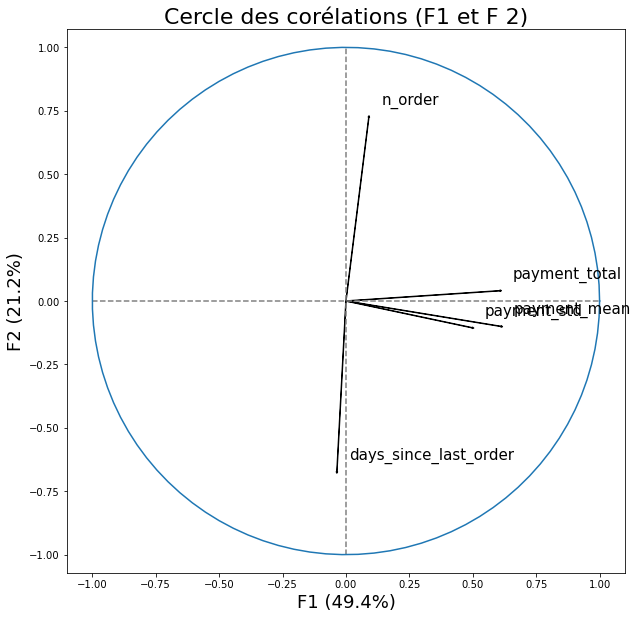

<Figure size 432x288 with 0 Axes>

In [54]:
x, y = 0,1 #define factorial space, (0,1) define the first factorial plane (F1, F2), (2,3) define the second (F3,F4) and so on(tuple)

fig, ax = plt.subplots(figsize = (10,10))
for i in range(0, pca.components_.shape[1]):
    ax.arrow(0,0, #start the arrow at the origin
                    pca.components_[0,i], #coordinate for PC1
                    pca.components_[1,i], #coordinate for PC2
                    head_width = 0.007,
                    head_length = 0.007,
                    width=0.002,) #graphical aspect of the arrow
    plt.text(pca.components_[0,i] + 0.05,
                        pca.components_[1,i] + 0.05,
                        features[i], fontsize = 15) # plot the text near each arrow head
plt.plot([-1,1], [0,0], color = 'grey', ls='--')
plt.plot([0,0], [-1,1], color='grey', ls='--') #plot the lines (abscissa and ordonate)

plt.xlabel('F{} ({}%)'.format(x+1, round(100*pca.explained_variance_ratio_[x],1)), fontsize = 18) #label the axis with the percentage of explained variance
plt.ylabel('F{} ({}%)'.format(y+1, round(100*pca.explained_variance_ratio_[y],1)),fontsize = 18)

plt.title('Cercle des cor√©lations (F{} et F {})'.format(x+1, y+1), fontsize = 22)

an = np.linspace(0, 2 * np.pi, 100) #return an np.array of the coordinates (100) of a circle of circonference 1 (2*pi)
plt.plot(np.cos(an), np.sin(an)) #plot the circle
plt.axis('equal') #set equal scaling
plt.show()
plt.clf()

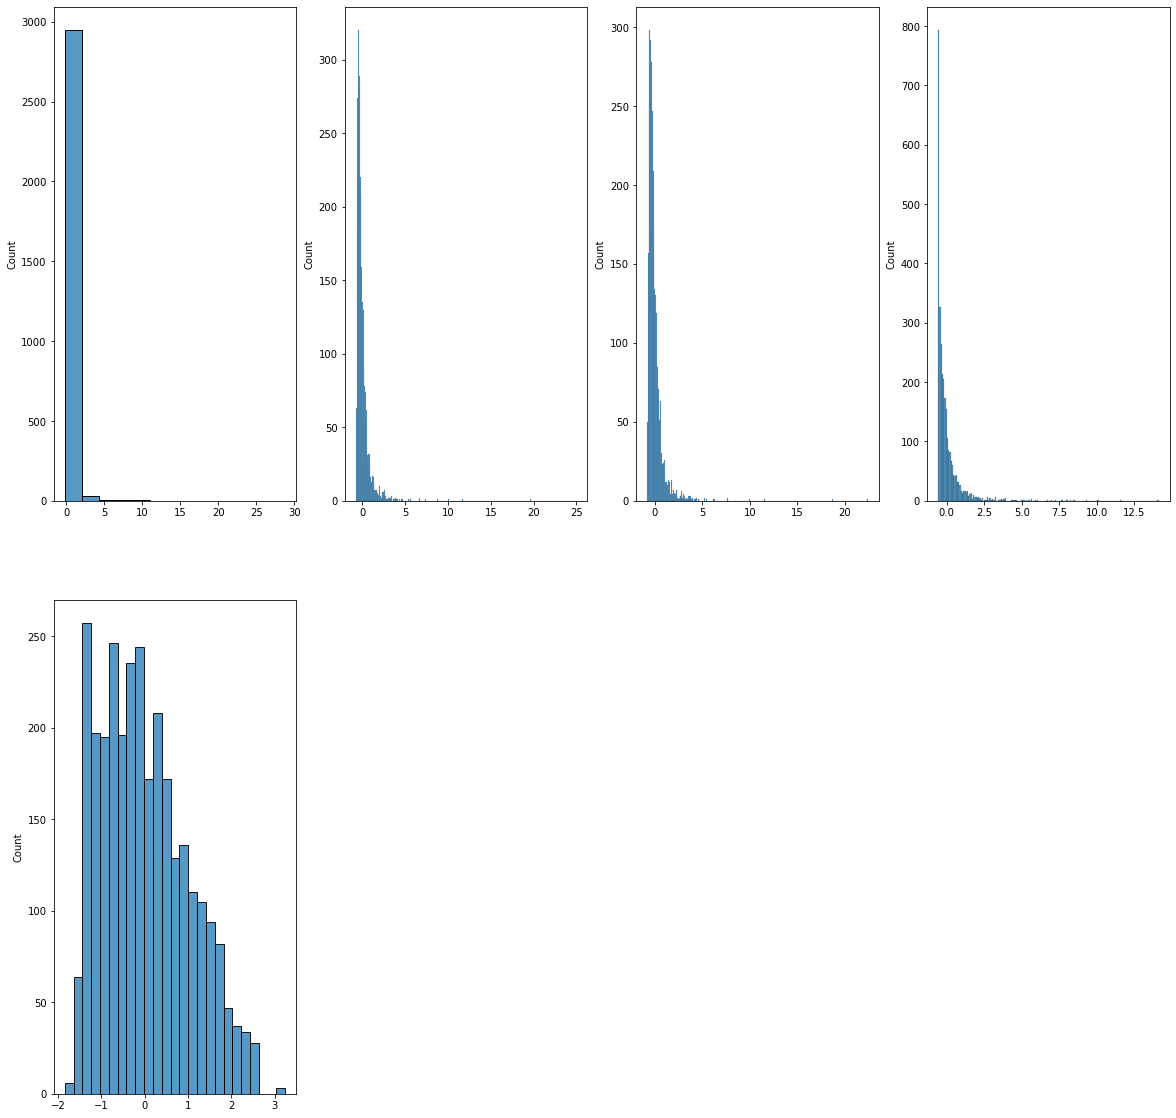

In [56]:
fig = plt.figure(figsize=(20,20))
for i in range(x_scale.shape[1]):
    ax = fig.add_subplot(int((x_scale.shape[1]/4)+1), 4, i+1)
    sns.histplot(x_scale[:,i], ax = ax)

plt.show()

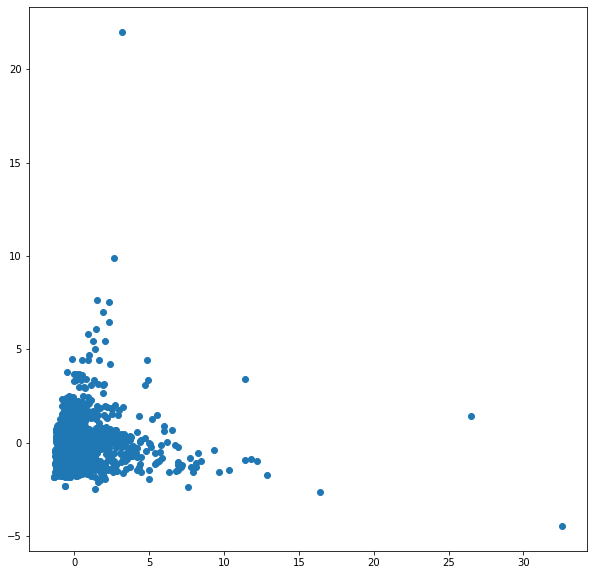

In [57]:
x_proj = pca.transform(x_scale)
fig, ax = plt.subplots(figsize = (10,10))
ax.scatter(x_proj[:,0],x_proj[:,1])
plt.show()

In [58]:
from sklearn import cluster, metrics

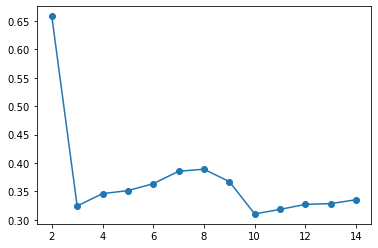

In [59]:
silhouette = []
for i in range(2,15):
    clus = cluster.KMeans(n_clusters = i)
    clus.fit(x_scale)
    sil  = metrics.silhouette_score(x_scale, clus.labels_)
    silhouette.append(sil)
    
plt.plot(range(2,15), silhouette, marker ='o')


In [60]:
from sklearn.manifold import Isomap
iso = Isomap()
from sklearn.manifold import MDS
mds = MDS()
from sklearn.manifold import TSNE
tsne = TSNE()

x_proj2 = mds.fit_transform(x_scale)
x_proj3 = tsne.fit_transform(x_scale)
x_proj4 = iso.fit_transform(x_scale)

E:\Data_Science\Anaconda\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
E:\Data_Science\Anaconda\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


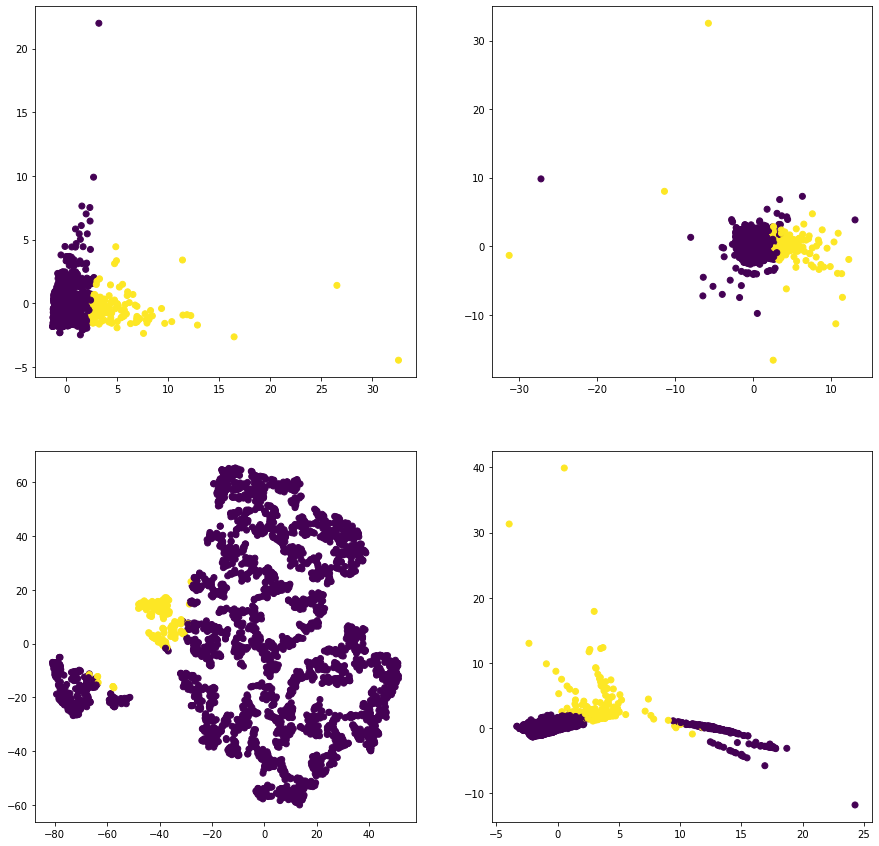

In [61]:
clus = cluster.KMeans(n_clusters = 2)
clus.fit(x_scale)

fig,ax =plt.subplots(2,2,figsize = (15,15))
ax[0,0].scatter(x_proj[:,0], x_proj[:,1], c=clus.labels_)
ax[0,1].scatter(x_proj2[:,0], x_proj2[:,1], c=clus.labels_)
ax[1,0].scatter(x_proj3[:,0], x_proj3[:,1], c=clus.labels_)
ax[1,1].scatter(x_proj4[:,0], x_proj4[:,1], c=clus.labels_)
plt.show()

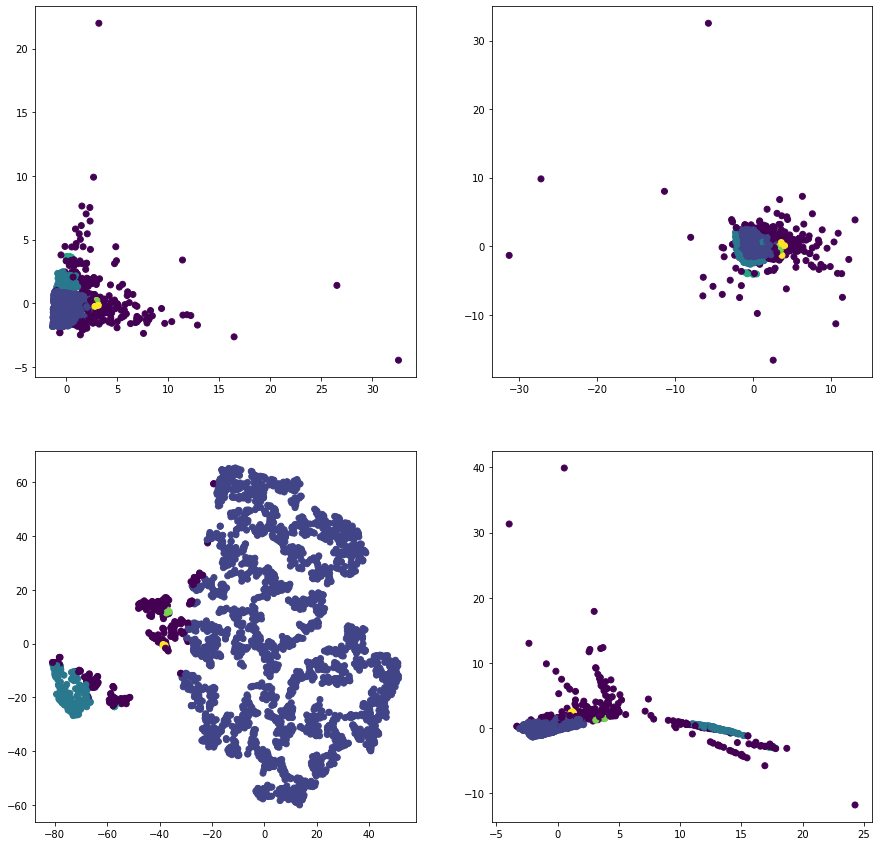

In [62]:
dbscan = cluster.DBSCAN()
dbscan.fit(x_scale)

fig,ax =plt.subplots(2,2,figsize = (15,15))
ax[0,0].scatter(x_proj[:,0], x_proj[:,1], c=dbscan.labels_)
ax[0,1].scatter(x_proj2[:,0], x_proj2[:,1], c=dbscan.labels_)
ax[1,0].scatter(x_proj3[:,0], x_proj3[:,1], c=dbscan.labels_)
ax[1,1].scatter(x_proj4[:,0], x_proj4[:,1], c=dbscan.labels_)
plt.show()

In [63]:
md_df['clus_label'] = clus.labels_
md_df['dbscan_label'] = dbscan.labels_

In [92]:
md_df.loc[md_df['clus_label'] == 0].describe()


n_order  payment_total  payment_mean  payment_std  \
count  2856.000000    2856.000000   2856.000000  2856.000000   
mean      2.114846     262.699419    124.231751    49.091984   
std       0.519440     168.464355     74.747617    56.607003   
min       2.000000      34.970000     15.620000     0.000000   
25%       2.000000     142.957500     70.156250     7.855956   
50%       2.000000     217.540000    105.263333    30.204066   
75%       2.000000     337.940000    160.400179    67.325404   
max      17.000000    1249.870000    523.575000   335.543381   

       days_since_last_order  clus_label  dbscan_label  
count            2856.000000      2856.0   2856.000000  
mean             1765.465336         0.0      0.023109  
std               145.986352         0.0      0.317871  
min              1496.000000         0.0     -1.000000  
25%              1649.000000         0.0      0.000000  
50%              1744.500000         0.0      0.000000  
75%              1866.000000         0.0      0.000000  
max              2236.000000         0.0      2.000000

In [93]:
md_df.loc[md_df['clus_label'] == 1].describe()

n_order  payment_total  payment_mean  payment_std  \
count  141.000000     141.000000    141.000000   141.000000   
mean     2.141844    1374.135957    640.072715   393.205207   
std      0.456408    1076.503098    442.943284   299.177604   
min      2.000000     607.550000    282.673333     0.000000   
25%      2.000000     871.530000    430.905000   203.130565   
50%      2.000000    1131.080000    519.940000   373.317025   
75%      2.000000    1467.870000    699.090000   500.391185   
max      5.000000    9553.020000   3785.815000  1646.887049   

       days_since_last_order  clus_label  dbscan_label  
count             141.000000       141.0    141.000000  
mean             1738.148936         1.0     -0.680851  
std               129.530908         0.0      1.166920  
min              1554.000000         1.0     -1.000000  
25%              1627.000000         1.0     -1.000000  
50%              1728.000000         1.0     -1.000000  
75%              1823.000000         1.0     -1.000000  
max              2060.000000         1.0      4.000000

In [ ]:
fig, ax = plt.subplots()
plt.subplots_adjust(top=0.15)

ax.axis('off')

ax.table(cellText = error_pnns.values,
         colLabels = error_pnns.columns,
         rowLabels = error_pnns.index,
         colColours = colcol,
         rowColours = rowcol,
         cellLoc='center',
         )

plt.savefig('table_error_pnns.png', bbox_inches = 'tight', dpi = 300)
plt.show()
plt.clf()

In [69]:
int(temp.shape[0]/3)+1

3

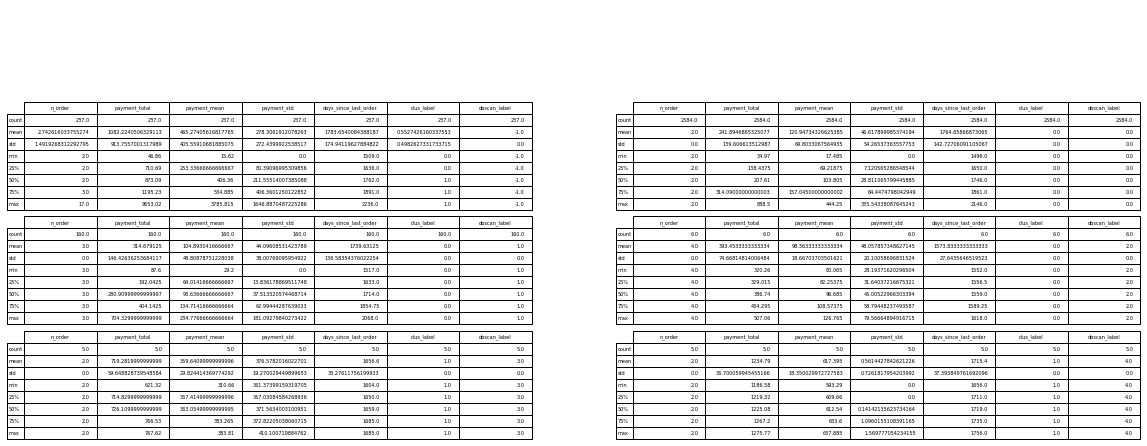

In [90]:
temp = np.unique(dbscan.labels_)
fig = plt.figure(figsize = (20,20))
plt.subplots_adjust(top=0.35)
for e,i in enumerate(temp):
    temp_df = pd.DataFrame(md_df.loc[md_df['dbscan_label'] == i].describe())
    ax = fig.add_subplot(int(temp.shape[0]/3)+1, 2, e+1)
    ax.axis('off')
    table = ax.table(cellText = temp_df.values,
            colLabels = temp_df.columns,
            rowLabels = temp_df.index,
            )
    table.set_fontsize = 15
plt.show()

In [91]:
for i in temp:
    print(md_df.loc[md_df['dbscan_label'] == i].describe())

          n_order  payment_total  payment_mean  payment_std  \
count  237.000000     237.000000    237.000000   237.000000   
mean     2.742616    1082.224051    465.274056   278.306191   
std      1.491927     913.755700    405.559107   272.439992   
min      2.000000      46.860000     15.620000     0.000000   
25%      2.000000     710.690000    253.336667    80.390970   
50%      2.000000     873.090000    406.360000   211.555140   
75%      3.000000    1195.230000    534.885000   406.360125   
max     17.000000    9553.020000   3785.815000  1646.887049   

       days_since_last_order  clus_label  dbscan_label  
count             237.000000  237.000000         237.0  
mean             1783.654008    0.552743          -1.0  
std               174.941196    0.498263           0.0  
min              1509.000000    0.000000          -1.0  
25%              1636.000000    0.000000          -1.0  
50%              1762.000000    1.000000          -1.0  
75%              1891.000000    1